In [25]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
from polyglot.text import Text, Word

from collections import Counter

# Dataset

## Words without embeddings

In [42]:
with open('data/valid.txt', 'r', encoding="utf-8") as f:
    sentences = f.read().splitlines()

results = read_results("native", "None", "SVD", "valid")
    
kapotte_sents = 0
total_tokens = 0
goeie_sents = []
for idx, sentence in enumerate(sentences):
    
    sentence = sentence.replace("''", "")
    sentence = sentence.replace('``', "")
    # double whitespaces confuse the model, remove these.
    while "  " in sentence:
        sentence = sentence.replace("  ", " ")

    tokens = sentence.split()
    emb_sent = []
    for token in tokens:
        total_tokens += 1
        poly_word = Word(token.lower(), language="nl")
        try:
            emb_sent.append(poly_word.vector)
        except:
            kapotte_sents += 1
    goeie_sents.append(idx)

#filtered_results = [results[r] for r in goeie_sents]
print(kapotte_sents/total_tokens)

0.05347144305142256


## Word frequency distribution

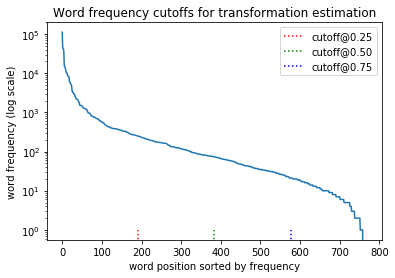

In [44]:
with open('data/filtered_en_nl_dict.txt', 'r', encoding="utf-8") as f:
    lines = f.read().splitlines()
    en_words_to_embed = [words.split('\t')[1] for words in lines]
    nl_words_to_embed = [words.split('\t')[0] for words in lines]


# Only use a fraction of the most common words when calculating the
# transformation
with open('data/train.txt', 'r', encoding="utf-8") as f:
    lines = f.read().splitlines()

tokens = []
for line in lines:
    tokens += [token.lower() for token in line.split()]
token_counts = Counter(tokens)
filt_token_counts = Counter({k: token_counts.get(k, 0) for k in nl_words_to_embed}).most_common(int(len(nl_words_to_embed)))
sorted_words = [w[0] for w in filt_token_counts]
sorted_values = [w[1] for w in filt_token_counts]

total_token_counts = sum(sorted_values)
plt.plot([v / total_token_counts for v in sorted_values])
plt.yscale("log")
plt.xlabel("word position sorted by frequency")
plt.ylabel("word frequency (log scale)")
cutoffs = [0.25, 0.5, 0.75]
cutoff_no = [int(c * len(nl_words_to_embed)) for c in cutoffs]
plt.vlines(cutoff_no[0], 0, 1, linestyles="dotted", color="r", label="cutoff@0.25")
plt.vlines(cutoff_no[1], 0, 1, linestyles="dotted", color="g",label="cutoff@0.50")
plt.vlines(cutoff_no[2], 0, 1, linestyles="dotted", color="b",label="cutoff@0.75")
plt.legend()
plt.title("Word frequency cutoffs for transformation estimation")
plt.savefig("./figures/word_frequency.png")
plt.show()

## Sentence length distribution

In [24]:
with open('data/valid.txt', 'r', encoding="utf-8") as f:
    validation_sentences = f.read().splitlines()

tokenized_sentences = [s.split() for s in validation_sentences]
sentence_lengths = [len(s) for s in tokenized_sentences]

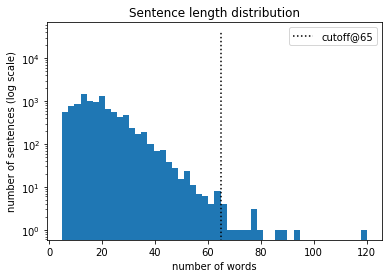

In [25]:
plt.hist(sentence_lengths, bins=50)
plt.yscale("log")
plt.ylabel("number of sentences (log scale)")
plt.xlabel("number of words")
plt.vlines(65, 0, 40000, linestyles="dotted", label="cutoff@65")
plt.legend()
plt.title("Sentence length distribution")
plt.savefig("./figures/sentence_length.png")
plt.show()

In [26]:
cutoff = 65

no_discarded_sents = len([s for s in sentence_lengths if s > cutoff])
rate_discarded = no_discarded_sents / len(sentence_lengths)
print(f'Ratio of sentences with lengths over {cutoff} words: {rate_discarded}')

Ratio of sentences with lengths over 65 words: 0.0014


# Result analysis

In [131]:
plt.rcParams["figure.figsize"] = (4, 4)

model_types = [
    "native",
    "cross_lingual"
]

cutoffs = [
    "0.25",
    "0.5",
    "0.75",
    "None"
]

transform_estimation_types = [
    "SGD",
    "SVD"
]

datasets = [
    "valid",
    "original-subject-verb-inverse",
    "subject-verb-inverse"
]

sgdcolor = 'orange'
svdcolor = 'green'

# template of the filename where results are stored
# `$modeltype_$transformestimationtype_$cutoff_cutoff_$dataset.txt`
#file_name_template = "./experiments/18-5--2315/{}_{}_{}_cutoff_{}.txt"
#file_name_template = "./experiments/19-5--1337/{}_{}_{}_cutoff_{}.txt"
file_name_template = "./experiments/{}_{}_{}_cutoff_{}.txt"

In [132]:
def read_results(model_type="cross_lingual", cutoff="None", transform_estimation_type="SGD", dataset="valid"):
    with open(file_name_template.format(model_type, transform_estimation_type, cutoff, dataset), "r") as f:
        file_content = f.read().splitlines()
    return [json.loads(r) for r in file_content]

def get_avg_perp(results):
    w = []
    for r in results:
        for w_p in r["perplexity"]:
            w.append(w_p)
    #return np.mean(w)
    return np.median(w)

def sort_by_perplexity(results, reverse=False):
    return sorted(results, key=lambda k: k["perplexity"])

def get_perplexity_by_index(sentence_index):
    pass


In [133]:
# get native results on validation set
file_name_template = "./experiments/{}_{}_{}_cutoff_{}.txt"

results = read_results("native", "None", "SVD", "valid")

native_perplexity_valid = get_avg_perp(results)
print(f"Median native per-word-perplexity on the validation set: {native_perplexity_valid}")

# get native results on validation set
results = read_results("native", "None", "SVD", "original-subject-verb-inverse")
native_perplexity_orig = get_avg_perp(results)
print(f"Median native per-sentence-perplexity on the original sentences in the POS-swap set: {native_perplexity_orig}")
results = read_results("native", "None", "SVD", "subject-verb-inverse")
native_perplexity_swapped = get_avg_perp(results)
print(f"Median native per-word-perplexity on the modified sentences in the POS-swap set: {native_perplexity_swapped}")

Median native per-word-perplexity on the validation set: 1.8306961059570312
Median native per-sentence-perplexity on the original sentences in the POS-swap set: 1.6238399744033813
Median native per-word-perplexity on the modified sentences in the POS-swap set: 3.256739616394043


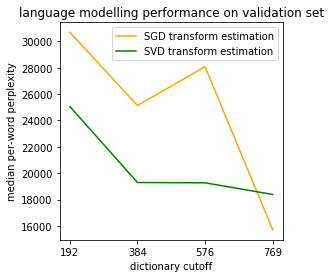

In [138]:
file_name_template = "./experiments/19-5--0143/{}_{}_{}_cutoff_{}.txt"

all_results = []
for transform_type in transform_estimation_types:
    tt_results = []
    for cutoff in cutoffs:
        tt_results.append(get_avg_perp(read_results(
            model_type="cross_lingual",
            cutoff=cutoff,
            transform_estimation_type=transform_type,
            dataset="valid"
        )))
    all_results.append(tt_results)

plt.plot(all_results[0], color=sgdcolor, label=f"{transform_estimation_types[0]} transform estimation")
plt.plot(all_results[1], color=svdcolor, label=f"{transform_estimation_types[1]} transform estimation")

xticks = np.array([0.25, 0.5, 0.75, 1]) * int(len(nl_words_to_embed))
plt.xticks([0, 1, 2, 3], [int(c) for c in xticks])

plt.ylabel("median per-word perplexity")
plt.title("language modelling performance on validation set")
#plt.hlines(native_perplexity_valid, xmin=0, xmax=3, linestyles="dotted", label="native model")
plt.xlabel("dictionary cutoff")
plt.legend()
plt.savefig("./figures/lang-mod-performance.png", bbox_inches='tight')
plt.show()

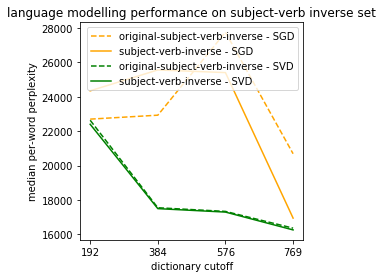

In [139]:
all_results = []
for tt in transform_estimation_types:
    tt_results = []
    for dataset in datasets[1:]:
        ds_results = []
        for cutoff in cutoffs:
            ds_results.append(get_avg_perp(read_results(
                model_type="cross_lingual",
                cutoff=cutoff,
                transform_estimation_type=tt,
                dataset=dataset
            )))
        tt_results.append(ds_results)
    all_results.append(tt_results)

plt.plot(all_results[0][0], '--', color=sgdcolor, label=f"{datasets[1:][0]} - {transform_estimation_types[0]}")
plt.plot(all_results[0][1], color=sgdcolor, label=f"{datasets[1:][1]} - {transform_estimation_types[0]}")
plt.plot(all_results[1][0], '--', color=svdcolor, label=f"{datasets[1:][0]} - {transform_estimation_types[1]}")
plt.plot(all_results[1][1],  color=svdcolor, label=f"{datasets[1:][1]} - {transform_estimation_types[1]}")
plt.xticks([0, 1, 2, 3], [int(c) for c in xticks])
plt.ylabel("median per-word perplexity")
plt.title("language modelling performance on subject-verb inverse set")
plt.xlabel("dictionary cutoff")
plt.legend()
plt.savefig("./figures/sub-inv-performance.png", bbox_inches='tight')
plt.show()

## Investigating the results

In [39]:
native_original_results = read_results("native", "None", "SVD", "original-subject-verb-inverse")
native_swapped_results = read_results("native", "None", "SVD", "subject-verb-inverse")

best_original_results = read_results(model_type="cross_lingual", cutoff="None", transform_estimation_type="SGD", dataset="original-subject-verb-inverse")
best_swapped_results = read_results(model_type="cross_lingual", cutoff="None", transform_estimation_type="SGD", dataset="subject-verb-inverse")

In [63]:
np.mean([[6344.35986328125], [1.3714627027511597], [1.0005017518997192], [1.008902907371521], [1.2326020002365112], [13975.60546875], [1.033113956451416], [1.0002384185791016], [1.000265121459961], [1.000112533569336], [1.000162124633789], [1.0003204345703125], [1.0021367073059082], [1.001338005065918], [1.0002537965774536], [1.000274658203125], [1.0001678466796875], [1.0015766620635986], [1.0621256828308105], [1092.395263671875], [289607.96875], [2231497.0], [248.27850341796875], [16601.541015625], [2699.279541015625], [1.0462393760681152]])

98541.73808463261

In [64]:
np.median([[6344.35986328125], [1.3714627027511597], [1.0005017518997192], [1.008902907371521], [1.2326020002365112], [13975.60546875], [1.033113956451416], [1.0002384185791016], [1.000265121459961], [1.000112533569336], [1.000162124633789], [1.0003204345703125], [1.0021367073059082], [1.001338005065918], [1.0002537965774536], [1.000274658203125], [1.0001678466796875], [1.0015766620635986], [1.0621256828308105], [1092.395263671875], [289607.96875], [2231497.0], [248.27850341796875], [16601.541015625], [2699.279541015625], [1.0462393760681152]])

1.0210084319114685

In [65]:
np.exp(15)

3269017.3724721107